In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NPROC'] = '1'
os.environ['JAX_ENABLE_X64'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
import numpyro

In [2]:
obs = jnp.concatenate([
    jax.random.normal(jax.random.key(0), (50,)) - 3,
    jax.random.normal(jax.random.key(1), (50,)) * 0.5 + 2,
])

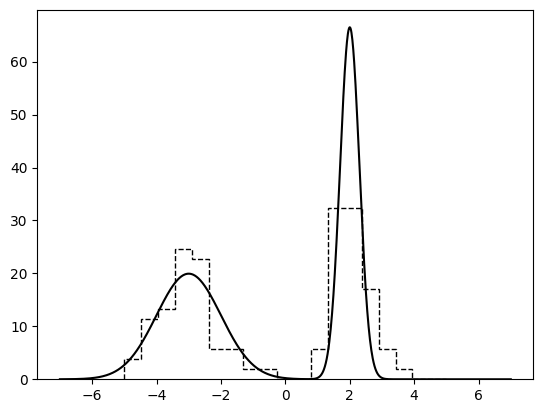

In [3]:
b = np.linspace(-5, 5, 20)
plt.hist(obs, bins = b, weights = 1 / np.full_like(obs, b[1]-b[0]), histtype = 'step', color = 'k', ls = '--')

x = jnp.linspace(-7, 7, 1_000)
truth = obs.size * 0.5 * (
    jax.scipy.stats.norm.pdf(x, -3, 1) + jax.scipy.stats.norm.pdf(x, 2, 0.3)
)
plt.plot(x, truth, c = 'k');

In [4]:
def gmm(x, w, mu, sigma):
    p = jax.scipy.stats.norm.pdf(x[:, None], mu, sigma)
    h = 1 # jax.scipy.stats.norm.pdf(mu, mu, sigma)
    return jnp.sum(w * p / h, axis = -1)

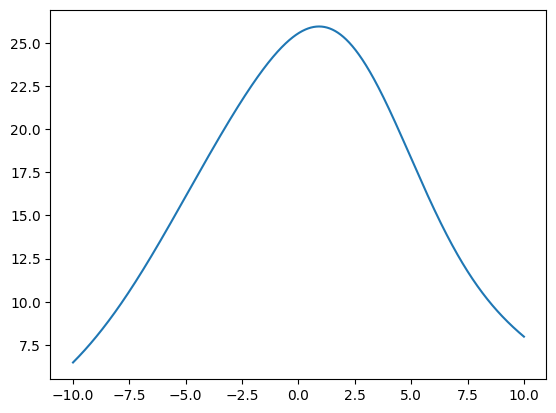

In [5]:
max_dim = 10
keys = jax.random.split(jax.random.key(np.random.randint(1e10)), 4)
masks = jax.random.randint(keys[0], (max_dim,), 0, 2)
w = jax.random.uniform(keys[1], (max_dim,)) * 100
mu = jax.random.uniform(keys[2], (max_dim,)) * 20 - 10
sigma = jax.random.uniform(keys[3], (max_dim,)) * 10
x = jnp.linspace(-10, 10, 1_000)
y = gmm(x, w * masks, mu, sigma)
plt.plot(x, y);

In [6]:
# Reorder x from largest to smallest value while preserving uniform density
# in the allowed region of parameters space.
# See Eq. (5) of https://arxiv.org/abs/1907.11631.

def order(x):
    k = x.size
    i = jnp.arange(k)
    y = jnp.power(1 - x, 1 / (k - i))
    y = jnp.cumprod(y)
    return y

# Have to make sure the change of variables results in the correct
# prior density for the sampled number of parameters n <= n_max.
# The masking must also act on arrays with static shapes for JAX jitting
# and be autodifferentiable.
# Below is one way to achieve this.

def masked_order(x, n):
    k = x.size
    i = jnp.arange(k)
    p = jnp.where(i < n, 1 / (n - i), 0)
    y = jnp.power(1 - x, p)
    y = jnp.cumprod(y)
    # y = jnp.where(i < n, y, 0)
    y = jnp.where(i < n, y, x)
    return y

## discrete

In [122]:
max_dim = 10

def model():
    with numpyro.plate('max_dim', max_dim):
        w = numpyro.sample('_w', numpyro.distributions.Uniform(0, 100))
        mu = numpyro.sample('mu', numpyro.distributions.Uniform(-10, 10))
        sigma = numpyro.sample('sigma', numpyro.distributions.Uniform(0, 10))

    #     masks = numpyro.sample('_masks', numpyro.distributions.DiscreteUniform())
    # n = numpyro.deterministic('n', masks.sum())
    # numpyro.factor('mask_prior', - numpyro.distributions.Binomial(max_dim, 0.5).log_prob(n))
    n = numpyro.sample('n', numpyro.distributions.DiscreteUniform(1, max_dim))
    masks = numpyro.deterministic('masks', jnp.less(jnp.arange(max_dim), n).astype(int))
    w = numpyro.deterministic('w', w * masks)

    x = jnp.linspace(-10, 10, 1_000)
    num = numpyro.deterministic('num', jnp.trapezoid(gmm(x, w, mu, sigma), x))
    numpyro.factor('ln_lkl', jnp.log(gmm(obs, w, mu, sigma)).sum() - num)

In [123]:
kernel = numpyro.infer.NUTS(model)
kernel = numpyro.infer.DiscreteHMCGibbs(kernel)
mcmc = numpyro.infer.MCMC(
    kernel, num_warmup = 1_000, num_samples = 1_000,
    # num_chains = 10, chain_method = jax.vmap, progress_bar = True,
)
mcmc.run(jax.random.key(42))
mcmc.print_summary()

sample: 100%|████████████████████████| 2000/2000 [00:40<00:00, 49.01it/s, 7 steps of size 4.43e-01. acc. prob=0.88]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     _w[0]     51.12      7.44     51.00     39.01     62.99   1416.90      1.00
     _w[1]     50.81      6.76     50.42     39.72     61.83    935.86      1.00
     _w[2]     46.85     30.61     45.65      0.03     89.52    833.59      1.00
     _w[3]     50.20     29.67     50.93      0.03     90.15   1151.80      1.00
     _w[4]     51.30     29.38     53.31      8.98     98.57   1010.54      1.00
     _w[5]     49.20     28.31     49.39      5.36     93.56   1445.05      1.00
     _w[6]     48.77     30.47     49.56      1.01     91.91   1527.31      1.00
     _w[7]     50.04     29.43     48.77      3.95     93.96   1490.85      1.00
     _w[8]     49.88     29.24     50.87      3.22     91.97   2017.65      1.00
     _w[9]     47.83     29.12     47.24      0.37     89.49   1066.13      1.00
     mu[0]      2.06      0.08      2.06      1.93      2.20   1484.68      1.00
     mu[1]     -3.11      0

In [124]:
posterior = {
    key: mcmc.get_samples()[key]
    for key in mcmc.get_samples() if key[0] != '_'
}

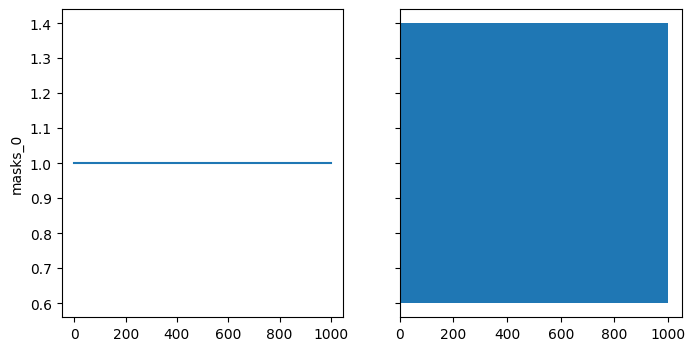

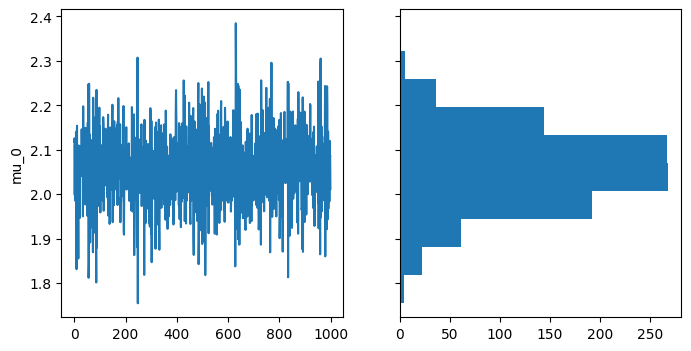

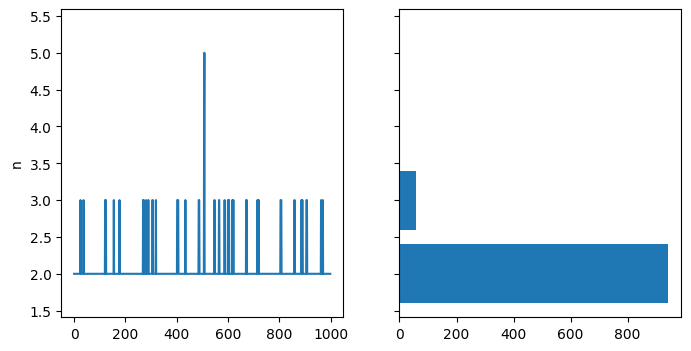

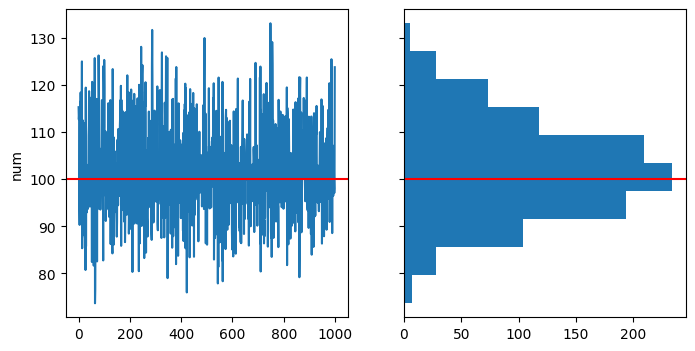

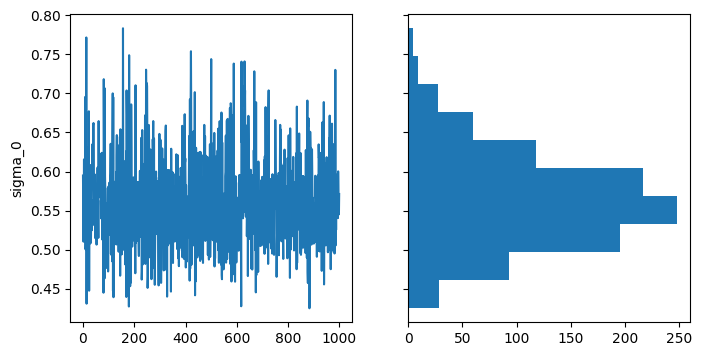

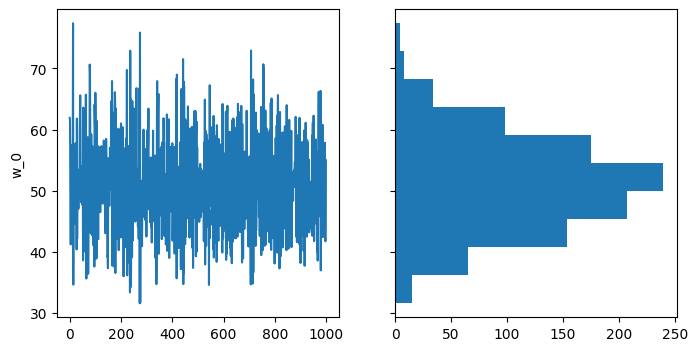

In [125]:
idx = 0
for key in posterior:
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4), sharey = True)
    samples = jnp.atleast_2d(posterior[key].T)[idx]
    axs[0].plot(samples)
    if samples.dtype == int:
        axs[1].barh(*np.unique(samples, return_counts = True))
    else:
        axs[1].hist(samples, orientation = 'horizontal')
    if key == 'num':
        for ax in axs:
            ax.axhline(obs.size, c = 'r')
    label = key
    if len(posterior[key].shape) == 2:
        label += f'_{dim + idx if idx < 0 else idx}'
    axs[0].set_ylabel(label)

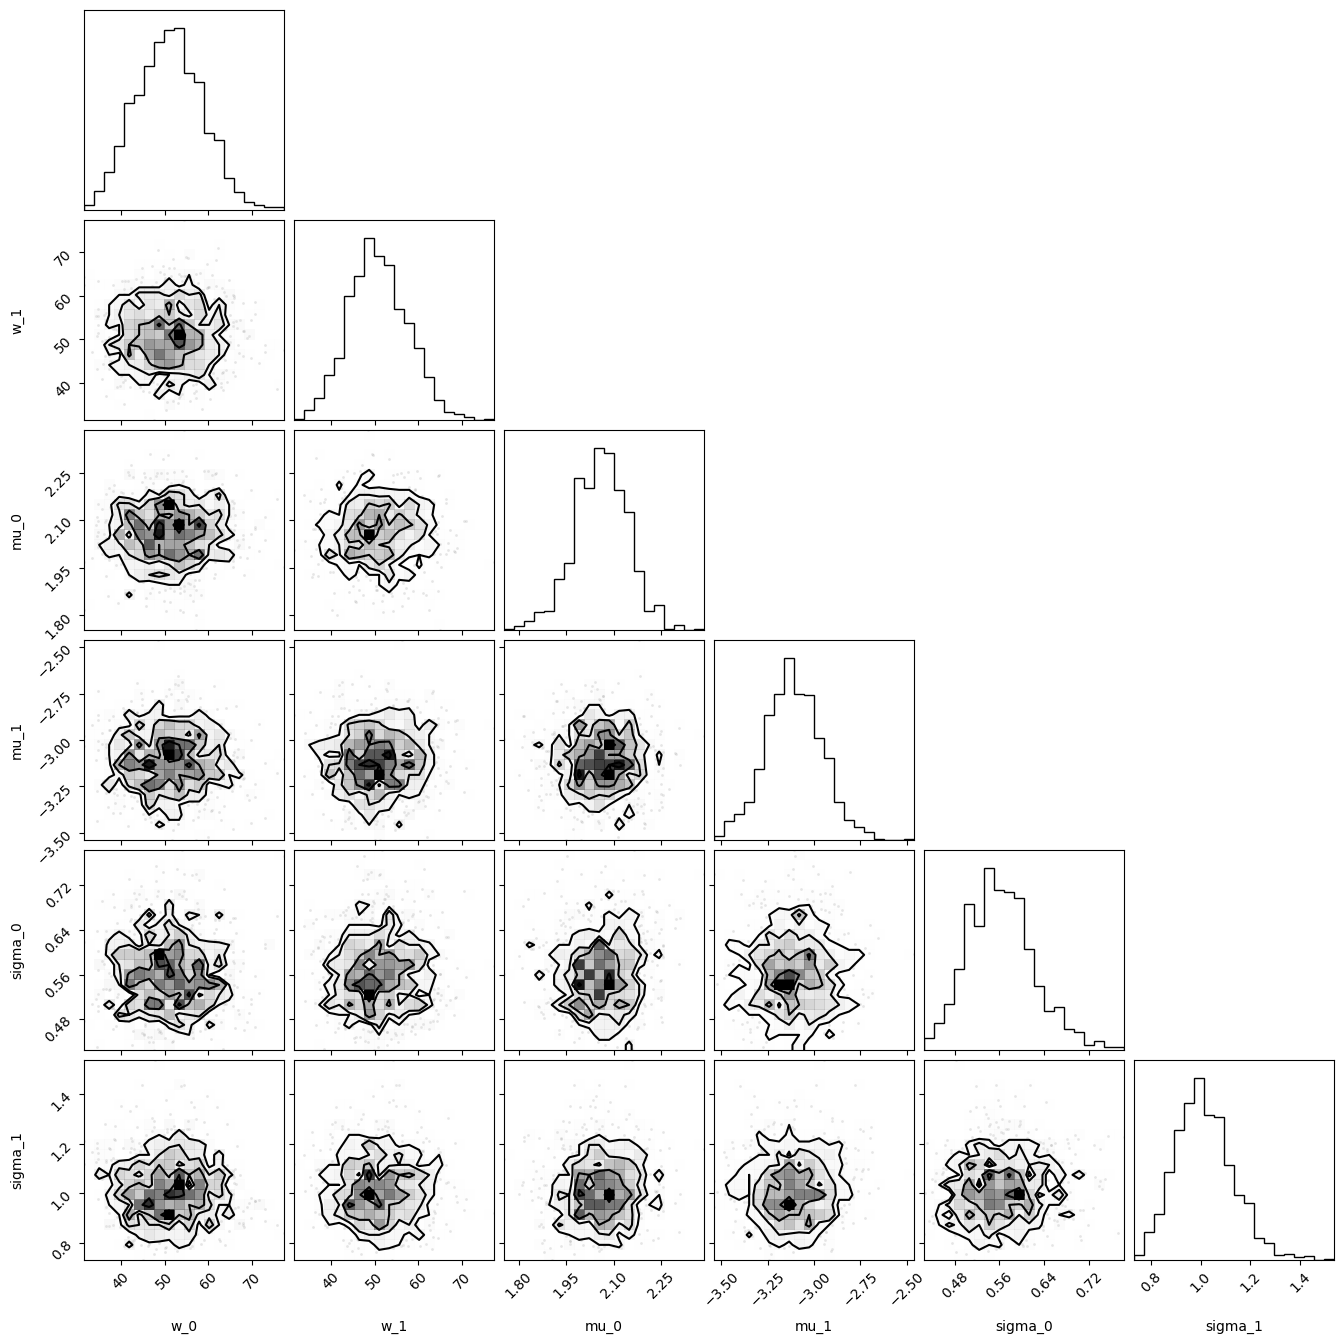

In [126]:
n = 2
keys = 'w', 'mu', 'sigma'
corner(
    np.concatenate([
        posterior[key][posterior['n'] == n, :n].T for key in keys
    ]).T,
    labels = [f'{key}_{i}' for key in keys for i in range(n)],
);

In [127]:
x = jnp.linspace(-10, 10, 1_000)
y = jax.lax.map(
    lambda parameters: gmm(x, parameters['w'], parameters['mu'], parameters['sigma']),
    posterior,
)

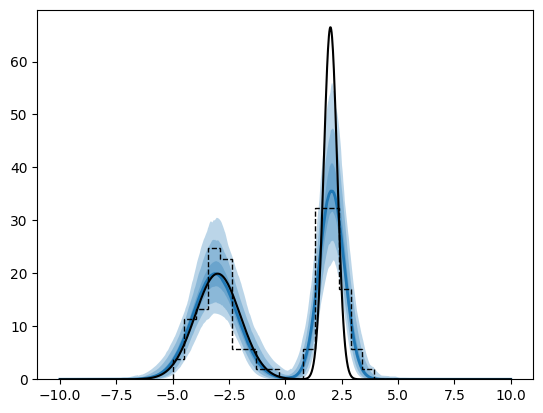

In [128]:
for levels in ((0.005, 0.995), (0.05, 0.95), (0.25, 0.75)):
    plt.fill_between(x, *np.quantile(y, levels, axis = 0), alpha = 0.3, color = 'C0', lw = 0)
plt.plot(x, np.median(y, axis = 0), lw = 2, c = 'C0')

b = np.linspace(-5, 5, 20)
plt.hist(obs, bins = b, weights = 1 / np.full_like(obs, b[1]-b[0]), histtype = 'step', color = 'k', ls = '--')

truth = obs.size * 0.5 * (
    jax.scipy.stats.norm.pdf(x, -3, 1) + jax.scipy.stats.norm.pdf(x, 2, 0.3)
)
plt.plot(x, truth, c = 'k');

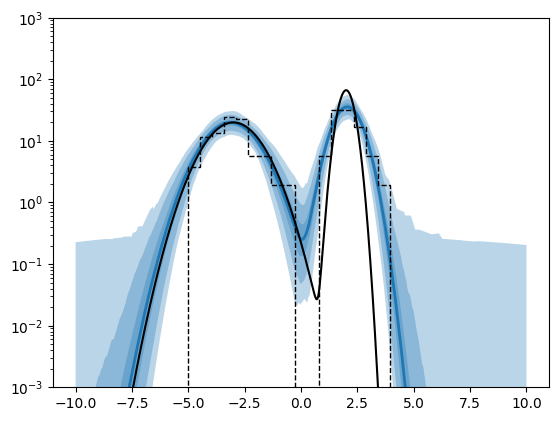

In [129]:
for levels in ((0.005, 0.995), (0.05, 0.95), (0.25, 0.75)):
    plt.fill_between(x, *np.quantile(y, levels, axis = 0), alpha = 0.3, color = 'C0', lw = 0)
plt.plot(x, np.median(y, axis = 0), lw = 2, c = 'C0')

b = np.linspace(-5, 5, 20)
plt.hist(obs, bins = b, weights = 1 / np.full_like(obs, b[1] - b[0]), histtype = 'step', color = 'k', ls = '--')

truth = obs.size * 0.5 * (
    jax.scipy.stats.norm.pdf(x, -3, 1) + jax.scipy.stats.norm.pdf(x, 2, 0.3)
)
plt.plot(x, truth, c = 'k')

plt.semilogy();
plt.ylim(1e-3, 1e3);

## continuous

In [52]:
max_dim = 10

def model():
    with numpyro.plate('max_dim', max_dim):
        w = numpyro.sample('_w', numpyro.distributions.Uniform(0, 100))
        mu = numpyro.sample('mu', numpyro.distributions.Uniform(-10, 10))
        sigma = numpyro.sample('sigma', numpyro.distributions.Uniform(0, 10))

    u = numpyro.sample('u', numpyro.distributions.Uniform(0, max_dim))
    mask = jnp.arange(max_dim) < u
    n = numpyro.deterministic('n', mask.sum())
    w = numpyro.deterministic('w', w * mask)

    x = jnp.linspace(-10, 10, 1_000)
    num = numpyro.deterministic('num', jnp.trapezoid(gmm(x, w, mu, sigma), x))
    numpyro.factor('ln_lkl', jnp.log(gmm(obs, w, mu, sigma)).sum() - num)

In [54]:
kernel = numpyro.infer.NUTS(model, max_tree_depth = 5, target_accept_prob = 0.9)
mcmc = numpyro.infer.MCMC(
    kernel, num_warmup = 1_000, num_samples = 1_000,
    # num_chains = 10, chain_method = 'vectorized', progress_bar = True,
)
mcmc.run(jax.random.key(42))
mcmc.print_summary()

sample: 100%|███████████████████████| 2000/2000 [00:41<00:00, 48.54it/s, 31 steps of size 3.26e-02. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     _w[0]     50.43      8.50     49.67     36.49     62.63     26.11      1.17
     _w[1]     53.19      7.11     52.81     40.70     63.20     29.82      1.02
     _w[2]     43.73     27.28     42.04      0.62     85.00     13.29      1.25
     _w[3]     52.66     28.27     52.78     12.41     99.87     77.92      1.01
     _w[4]     50.35     30.42     50.71      0.95     92.21     58.88      1.04
     _w[5]     49.05     28.12     48.87      4.85     91.04    127.64      1.01
     _w[6]     51.35     29.16     53.92     10.87     98.76     60.03      1.09
     _w[7]     43.95     27.96     42.86      0.08     84.57     75.42      1.00
     _w[8]     45.55     28.21     43.46      0.83     87.96    148.11      1.03
     _w[9]     49.21     31.60     48.22      0.00     94.24     12.92      1.00
     mu[0]     -3.10      0.13     -3.10     -3.30     -2.86    100.10      1.01
     mu[1]      2.05      0

In [55]:
posterior = {
    key: mcmc.get_samples()[key]
    for key in mcmc.get_samples() if key[0] != '_'
}

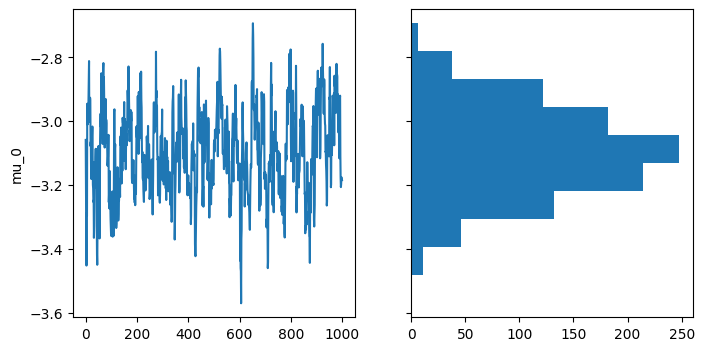

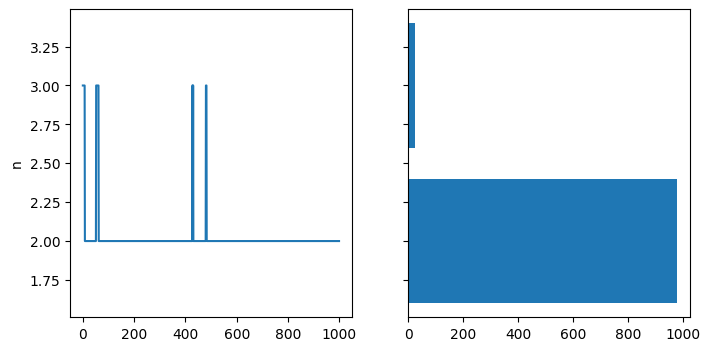

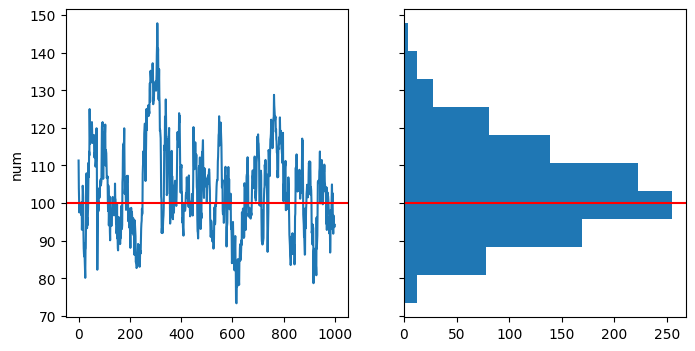

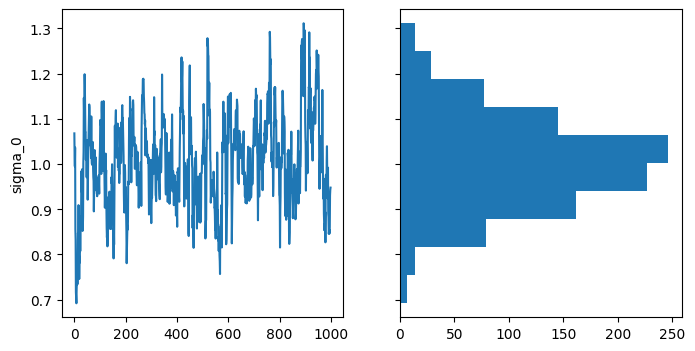

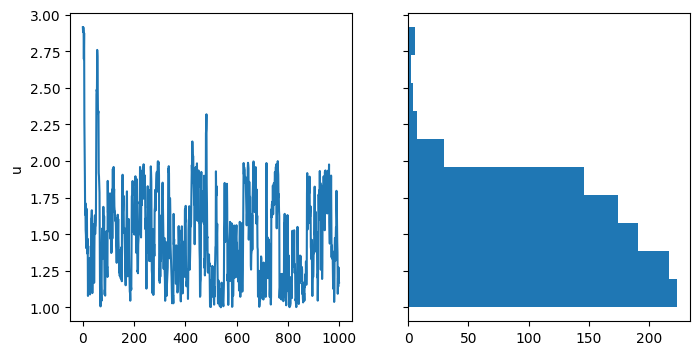

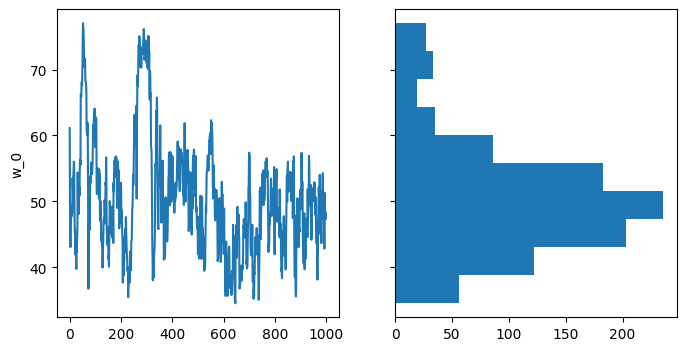

In [56]:
idx = 0
for key in posterior:
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4), sharey = True)
    samples = jnp.atleast_2d(posterior[key].T)[idx]
    axs[0].plot(samples)
    if samples.dtype == int:
        axs[1].barh(*np.unique(samples, return_counts = True))
    else:
        axs[1].hist(samples, orientation = 'horizontal')
    if key == 'num':
        for ax in axs:
            ax.axhline(obs.size, c = 'r')
    label = key
    if len(posterior[key].shape) == 2:
        label += f'_{dim + idx if idx < 0 else idx}'
    axs[0].set_ylabel(label)

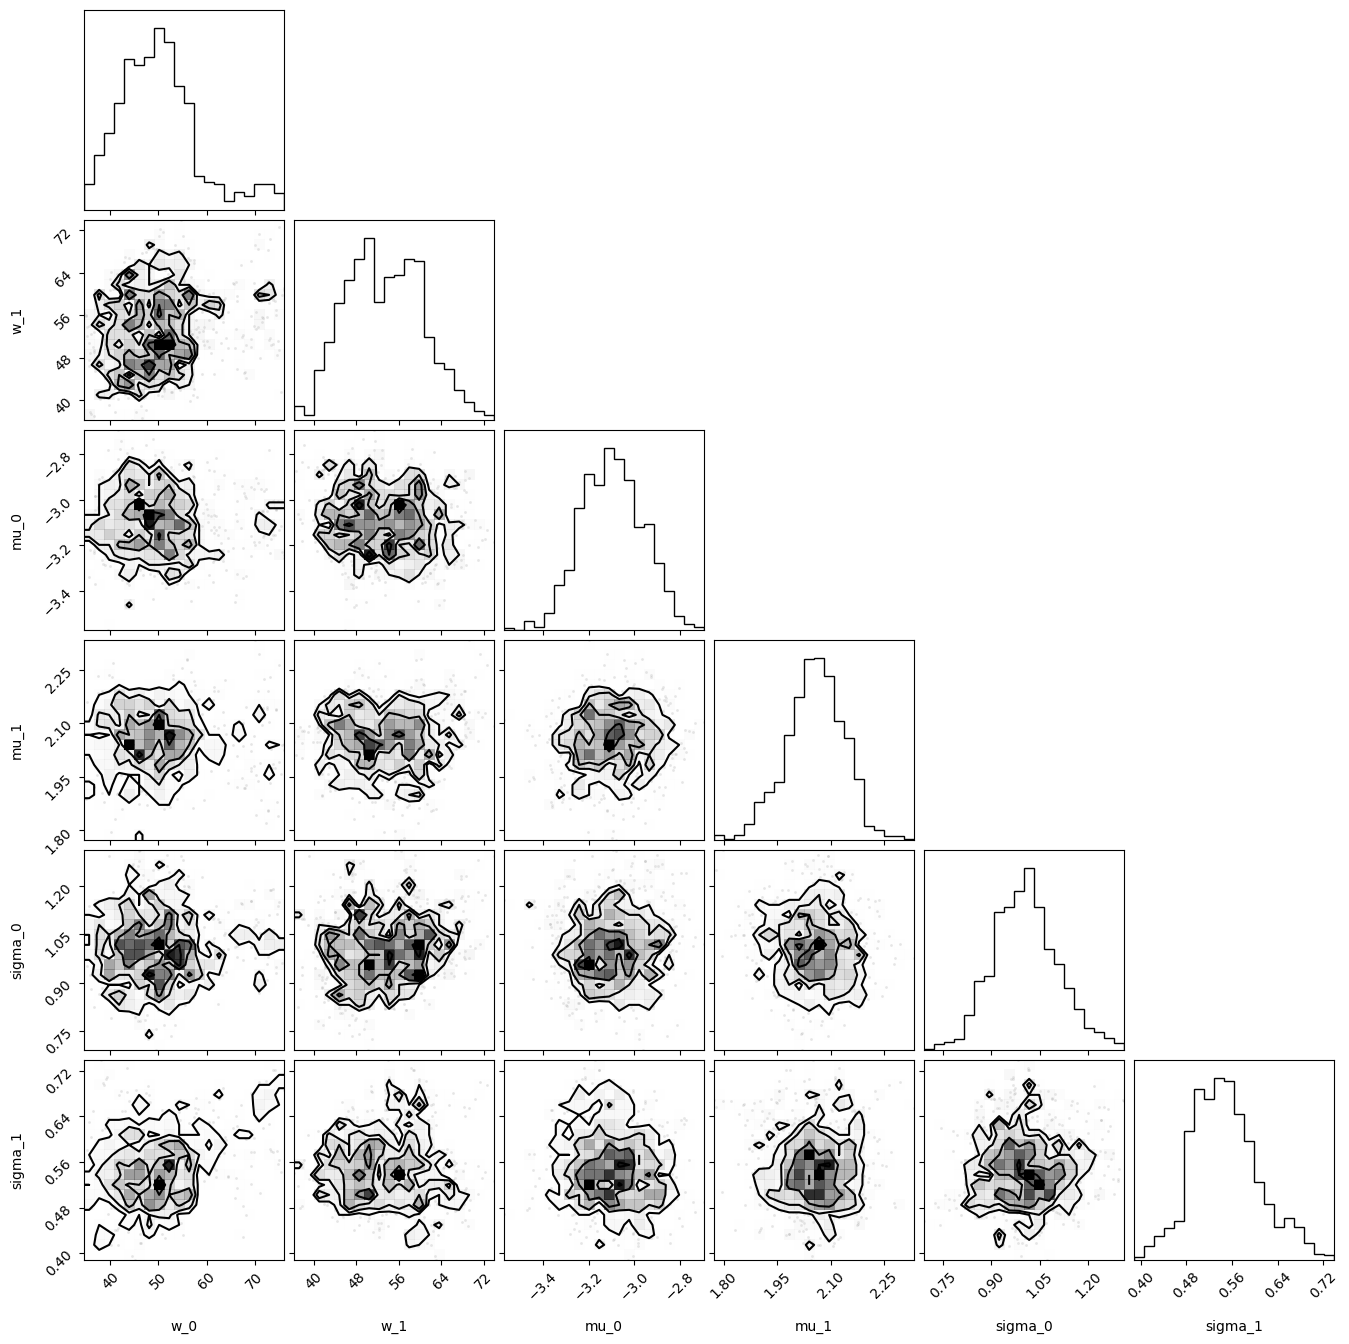

In [57]:
n = 2
keys = 'w', 'mu', 'sigma'
corner(
    np.concatenate([
        posterior[key][posterior['n'] == n, :n].T for key in keys
    ]).T,
    labels = [f'{key}_{i}' for key in keys for i in range(n)],
);

In [58]:
x = jnp.linspace(-10, 10, 1_000)
y = jax.lax.map(
    lambda parameters: gmm(x, parameters['w'], parameters['mu'], parameters['sigma']),
    posterior,
)

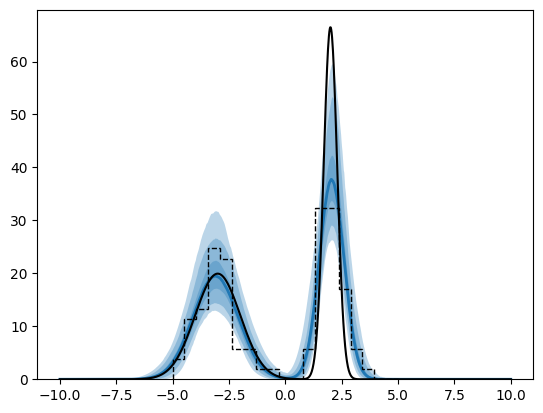

In [59]:
for levels in ((0.005, 0.995), (0.05, 0.95), (0.25, 0.75)):
    plt.fill_between(x, *np.quantile(y, levels, axis = 0), alpha = 0.3, color = 'C0', lw = 0)
plt.plot(x, np.median(y, axis = 0), lw = 2, c = 'C0')

b = np.linspace(-5, 5, 20)
plt.hist(obs, bins = b, weights = 1 / np.full_like(obs, b[1]-b[0]), histtype = 'step', color = 'k', ls = '--')

truth = obs.size * 0.5 * (
    jax.scipy.stats.norm.pdf(x, -3, 1) + jax.scipy.stats.norm.pdf(x, 2, 0.3)
)
plt.plot(x, truth, c = 'k');

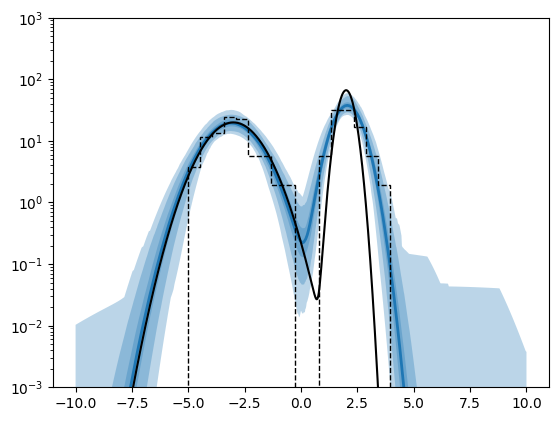

In [60]:
for levels in ((0.005, 0.995), (0.05, 0.95), (0.25, 0.75)):
    plt.fill_between(x, *np.quantile(y, levels, axis = 0), alpha = 0.3, color = 'C0', lw = 0)
plt.plot(x, np.median(y, axis = 0), lw = 2, c = 'C0')

b = np.linspace(-5, 5, 20)
plt.hist(obs, bins = b, weights = 1 / np.full_like(obs, b[1]-b[0]), histtype = 'step', color = 'k', ls = '--')

truth = obs.size * 0.5 * (
    jax.scipy.stats.norm.pdf(x, -3, 1) + jax.scipy.stats.norm.pdf(x, 2, 0.3)
)
plt.plot(x, truth, c = 'k')
plt.semilogy()
plt.ylim(1e-3, 1e3);